In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
import numpy as np
import datetime
import os, sys
import glob
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [7]:
MODEL_NAME = 'BEGAN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
IMAGE_DIM = (64, 64, 3)

In [9]:
def tensor2img(tensor):
    img = (np.transpose(tensor.detach().cpu().numpy(), [1,2,0])+1)/2.
    return img

In [10]:
def get_sample_image(G, n_noise=100, n_samples=64):
    """
        save sample 100 images
    """
    n_rows = int(np.sqrt(n_samples))
    z = (torch.rand(size=[n_samples, n_noise])*2-1).to(DEVICE) # U[-1, 1]
    x_fake = G(z)
    x_fake = torch.cat([torch.cat([x_fake[n_rows*j+i] for i in range(n_rows)], dim=1) for j in range(n_rows)], dim=2)
    result = tensor2img(x_fake)
    return result

In [11]:
class Encoder(nn.Module):
    """
        Convolutional Encoder
    """
    def __init__(self, in_channel=1, n_filters=128, hidden_dim=100):
        super(Encoder, self).__init__()
        assert IMAGE_DIM[0] % 2**2 == 0, 'Should be divided 4'
        self.flatten_dim = IMAGE_DIM[0]//2**2
        self.conv = nn.Sequential(
            # conv0
            nn.Conv2d(in_channel, n_filters, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(n_filters),
            nn.LeakyReLU(0.2),
            # conv1
            nn.Conv2d(n_filters, n_filters, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(n_filters),
            nn.LeakyReLU(0.2),
            # conv2
            nn.Conv2d(n_filters, n_filters*2, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n_filters*2),
            nn.LeakyReLU(0.2),
            # conv3
            nn.Conv2d(n_filters*2, n_filters*2, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(n_filters*2),
            nn.LeakyReLU(0.2),
            # conv4
            nn.Conv2d(n_filters*2, n_filters*3, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(n_filters*3),
            nn.LeakyReLU(0.2),
            # conv5
            nn.Conv2d(n_filters*3, n_filters*3, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(n_filters*3),
            nn.LeakyReLU(0.2),
            # conv6
            nn.Conv2d(n_filters*3, n_filters*3, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(n_filters*3),
            nn.LeakyReLU(0.2),
#             nn.AdaptiveAvgPool2d(1),
        )
        self.fc = nn.Linear(self.flatten_dim**2*n_filters*3, hidden_dim)
    
    def forward(self, x):
        h = self.conv(x)
        h = h.view(h.size(0), -1)
        h = self.fc(h)
        return h

In [12]:
class Decoder(nn.Module):
    """
        Convolutional Decoder
    """
    def __init__(self, out_channel=1, n_filters=128, n_noise=100):
        super(Decoder, self).__init__()
        assert IMAGE_DIM[0] % 2**2 == 0, 'Should be divided 4'
        self.flatten_dim = IMAGE_DIM[0]//2**2
        self.fc = nn.Sequential(
            nn.Linear(n_noise, self.flatten_dim**2*n_filters),
        )
        self.conv = nn.Sequential(
            # conv1
            nn.Conv2d(n_filters, n_filters, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(n_filters),
            nn.LeakyReLU(0.2),
            # conv2
            nn.Conv2d(n_filters, n_filters, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(n_filters),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2, mode='nearest'),
            # conv3
            nn.Conv2d(n_filters, n_filters, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(n_filters),
            nn.LeakyReLU(0.2),
            # conv4
            nn.Conv2d(n_filters, n_filters, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(n_filters),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2, mode='nearest'),
            # conv5
            nn.Conv2d(n_filters, n_filters, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(n_filters),
            nn.LeakyReLU(0.2),
            # conv6
            nn.Conv2d(n_filters, n_filters, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(n_filters),
            nn.LeakyReLU(0.2),
            # conv6
            nn.Conv2d(n_filters, out_channel, 3, stride=1, padding=1, bias=True),
            nn.Tanh()
        )
    
    def forward(self, h):
        h = self.fc(h)
        h = h.view(h.size(0), -1, self.flatten_dim, self.flatten_dim)
        x = self.conv(h)
        return x

In [13]:
class Discriminator(nn.Module):
    """
        Convolutional Discriminator
    """
    def __init__(self, in_channel=1, n_filters=128, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.encoder = Encoder(in_channel=in_channel, n_filters=n_filters, hidden_dim=hidden_dim)
        self.decoder = Decoder(out_channel=in_channel, n_filters=n_filters, n_noise=hidden_dim)
        
    def forward(self, x):
        h = self.encoder(x)
        x_ = self.decoder(h)
        return x_

In [14]:
class Generator(nn.Module):
    """
        Convolutional Generator
    """
    def __init__(self, out_channel=1, n_filters=128, n_noise=64):
        super(Generator, self).__init__()
        self.decoder = Decoder(out_channel=out_channel, n_filters=n_filters, n_noise=n_noise)
        
    def forward(self, h):
        x_ = self.decoder(h)
        return x_

In [15]:
# Connecting and Mounting to the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
data_dir = '/content/drive/MyDrive/EgyptianHieroglyphDataset_Original_Clean'

In [17]:
def get_class_distribution(dataset_obj, idx2class):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for element in dataset_obj:
        y_lbl = element[1]
        y_lbl = idx2class[y_lbl]
        count_dict[y_lbl] += 1
            
    return count_dict

In [18]:
def load_data(hieroglyph_directory_path, batch_size=20, num_workers=0):
    train_dir = os.path.join(hieroglyph_directory_path, 'train/')
    test_dir = os.path.join(hieroglyph_directory_path, 'test/')

    classes = []

    for filename in os.listdir(train_dir):
        if filename == '.DS_Store':
            pass
        else:
            classes.append(filename)

    classes.sort()

    # print("Our classes:", classes)
    # print(len(classes))

    data_transform = transforms.Compose([transforms.ToTensor(),
                                            #transforms.RandomApply([transforms.RandomHorizontalFlip()]),
                                            #transforms.RandomRotation(degrees=(-10, 10)),
                                            #transforms.RandomAffine(degrees=0, translate=(.1, .1)),
                                            
                                            #transforms.RandomApply([transforms.ColorJitter(brightness=(1, 1.2),
                                                                                            #contrast=(1, 1.5),
                                                                                            #saturation=(1, 1.5),
                                                                                            #hue=(0, 0.5))]),
                                            
                                            #transforms.RandomErasing(p=0.5, scale=(0.05, 0.05), ratio=(0.3, 3.3), value=0,
                                                                      #inplace=False),
                                            transforms.Resize((64, 64)),
                                            transforms.Normalize((0.5,), (0.5,))])

    train_data = datasets.ImageFolder(train_dir, transform=data_transform)
    test_data = datasets.ImageFolder(test_dir, transform=data_transform)

    # print('Num training images: ', len(train_data))
    # print('Num test images: ', len(test_data))

    # WeightedRandomSampler for train loader
    idx2class = {v: k for k, v in train_data.class_to_idx.items()}

    target_list = torch.tensor(train_data.targets)
    class_count = [i for i in get_class_distribution(train_data, idx2class).values()]
    class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
    class_weights_all = class_weights[target_list]
    weighted_sampler = torch.utils.data.WeightedRandomSampler(weights=class_weights_all, num_samples=len(class_weights_all), replacement=True)

    # prepare data loaders
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                               num_workers=num_workers, sampler=weighted_sampler, drop_last=True)
    
    # WeightedRandomSampler for test loader
    idx2class_test = {v: k for k, v in test_data.class_to_idx.items()}

    target_list_test = torch.tensor(test_data.targets)
    class_count_test = [i for i in get_class_distribution(test_data, idx2class_test).values()]
    class_weights_test = 1./torch.tensor(class_count_test, dtype=torch.float) 
    class_weights_all_test = class_weights_test[target_list_test]
    weighted_sampler_test = torch.utils.data.WeightedRandomSampler(weights=class_weights_all_test, num_samples=len(class_weights_all_test), replacement=True)

    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                              num_workers=num_workers, sampler=weighted_sampler_test)

    return train_loader, test_loader, classes

In [19]:
# Number of images processed in a single training
batch_size = 20
num_workers = 0

# The load_data function is from hieroglyph_data_preparation python file
data_loader, test_loader, classes = load_data(data_dir)

In [20]:
batch_size = 32
n_noise = 64

In [21]:
D = Discriminator(in_channel=IMAGE_DIM[-1], hidden_dim=n_noise).to(DEVICE)
G = Generator(out_channel=IMAGE_DIM[-1], n_noise=n_noise).to(DEVICE)

In [22]:
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [23]:
# BEGAN causes mode collapse. it can be addressed by decaying lr
D_scheduler = torch.optim.lr_scheduler.MultiStepLR(D_opt, milestones=[3, 10, 17], gamma=0.6)
G_scheduler = torch.optim.lr_scheduler.MultiStepLR(G_opt, milestones=[3, 10, 17], gamma=0.6)

In [24]:
criterion = nn.L1Loss()

In [25]:
max_epoch = 100
step = 0

In [26]:
lr_k = 0.001
gamma = 0.7
k_t = 0
log_term = 1000

In [27]:
steps_per_epoch = len(data_loader.dataset) // batch_size
steps_per_epoch

77

In [28]:
if not os.path.exists('samples'):
    os.makedirs('samples')
    
if not os.path.exists('ckpt'):
    os.makedirs('ckpt')

In [29]:
def save_checkpoint(state, file_name='checkpoint.pth.tar'):
    torch.save(state, file_name)

In [30]:
m_lst = []
bestM = 1.
for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(data_loader):
        G.zero_grad()
        # Training Discriminator
        x = images.to(DEVICE)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, x)

        z = (torch.rand(size=[batch_size, n_noise])*2-1).to(DEVICE)
        x_fake = G(z)
        z_outputs = D(x_fake.detach())
        D_z_loss = criterion(z_outputs, x_fake)
        
        D_loss = D_x_loss - k_t*D_z_loss
        
        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        # Training Generator
        z = (torch.rand(size=[batch_size, n_noise])*2-1).to(DEVICE)
        x_fake = G(z)
        z_outputs = D(x_fake)
        G_loss = criterion(x_fake, z_outputs)

        G.zero_grad()
        G_loss.backward()
        G_opt.step()
        
        bal = (gamma*D_x_loss - G_loss).detach()
        k_t = min(max(k_t + lr_k*bal, 0), 1)
        M_global = D_x_loss.detach() + torch.abs(bal)
        
        if M_global.item() < bestM:
            bestM = M_global.item()
            save_checkpoint({'global_step': step,
                 'D':D.state_dict(),
                 'G':G.state_dict(),
                 'd_optim': D_opt.state_dict(),
                 'g_optim' : G_opt.state_dict()},
                'ckpt/began{:06d}.pth.tar'.format(step))
        
        if step % log_term == 0:
            m_lst.append(M_global)
            dt = datetime.datetime.now().strftime('%H:%M:%S')
            print('Epoch: {}/{}, Step: {}, D Loss: {:.4f}, G Loss: {:.4f}, k: {:.4f}, M: {:.4f}, lr: {:.7f}, Time:{}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item(), k_t, M_global.item(), G_scheduler.get_lr()[0], dt))
            G.eval()
            img = get_sample_image(G, n_noise, n_samples=25)
            imsave('samples/{}_step{:06d}.jpg'.format(MODEL_NAME, step), img)
            G.train()
        
        step += 1
    D_scheduler.step()
    G_scheduler.step()

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Epoch: 0/100, Step: 0, D Loss: 0.5510, G Loss: 0.4300, k: 0.0000, M: 0.5953, lr: 0.0002000, Time:20:03:46
Epoch: 8/100, Step: 1000, D Loss: 0.0517, G Loss: 0.0399, k: 0.0067, M: 0.0554, lr: 0.0001200, Time:20:11:04
Epoch: 16/100, Step: 2000, D Loss: 0.0478, G Loss: 0.0398, k: 0.0092, M: 0.0542, lr: 0.0000720, Time:20:17:47
Epoch: 24/100, Step: 3000, D Loss: 0.0501, G Loss: 0.0357, k: 0.0079, M: 0.0508, lr: 0.0000432, Time:20:24:30
Epoch: 32/100, Step: 4000, D Loss: 0.0390, G Loss: 0.0247, k: 0.0066, M: 0.0418, lr: 0.0000432, Time:20:31:15
Epoch: 40/100, Step: 5000, D Loss: 0.0434, G Loss: 0.0240, k: 0.0118, M: 0.0503, lr: 0.0000432, Time:20:37:56
Epoch: 48/100, Step: 6000, D Loss: 0.0374, G Loss: 0.0328, k: 0.0132, M: 0.0441, lr: 0.0000432, Time:20:44:36
Epoch: 56/100, Step: 7000, D Loss: 0.0340, G Loss: 0.0278, k: 0.0114, M: 0.0381, lr: 0.0000432, Time:20:51:17
Epoch: 65/100, Step: 8000, D Loss: 0.0434, G Loss: 0.0266, k: 0.0095, M: 0.0476, lr: 0.0000432, Time:20:57:57
Epoch: 73/100, 

In [31]:
save_checkpoint({'global_step': step,
     'D':D.state_dict(),
     'G':G.state_dict(),
     'd_optim': D_opt.state_dict(),
     'g_optim' : G_opt.state_dict()},
    'ckpt/began{:06d}.pth.tar'.format(step))

In [32]:
G_path = sorted(glob.glob(os.path.join('ckpt', '*.pth.tar')))[-2]
state = torch.load(G_path)
G.load_state_dict(state['G'])

<All keys matched successfully>

In [33]:
G.eval()
None

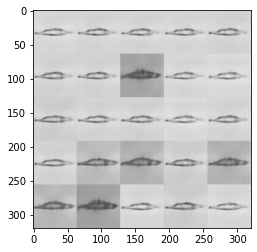

In [34]:
img = get_sample_image(G, n_noise, n_samples=25)
imshow(img)

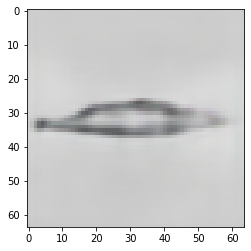

In [35]:
# Fake Image
idx = [3, 3]
row, col = IMAGE_DIM[0]*idx[0], IMAGE_DIM[1]*idx[1]
imshow(img[row:row+IMAGE_DIM[0], col:col+IMAGE_DIM[1], :])

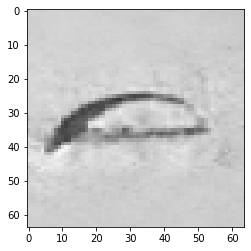

In [36]:
# Real Image
i = 14
rimg = tensor2img(images[i])
imshow(rimg)

In [37]:
def sample_noise(size=None):
    z = np.random.random(size=size)*2-1
    return z

In [38]:
z_a, z_b = sample_noise(n_noise), sample_noise(n_noise)
zs = torch.tensor([np.linspace(z_a[i], z_b[i], num=10) for i in range(n_noise)], dtype=torch.float32).to(DEVICE)
zs = torch.transpose(zs, 0, 1)
zs.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


torch.Size([10, 64])

In [39]:
imgs = G(zs).detach()
imgs = torch.cat([imgs[i] for i in range(10)], dim=-1)
imgs.shape

torch.Size([3, 64, 640])

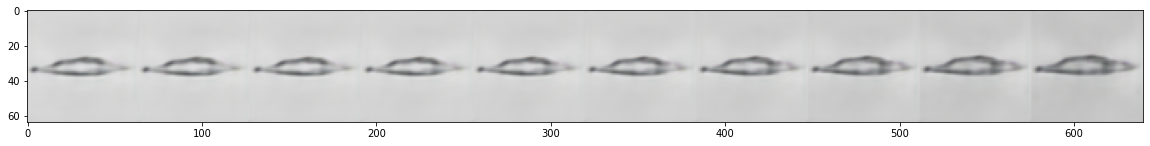

In [40]:
fig = plt.figure(figsize=(20, 3))
imshow(tensor2img(imgs))